# Get experiments

In [19]:
import os
import pandas as pd
from matplotlib import pyplot as plt

In [15]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


# Extend the experiment df with the experiment processed results

In [4]:
import numpy as np 

# TODO: Refactor all these functions to take into account that we also have abs spectra now

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [83]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            fl_int_norm = [yi/max(y) for yi in y]
            fl_auc_total = get_area_under_peaks(x, y)
            peaks, areas = process_spectrum(x, y, norm_area=1)
            fl_wvl, fl_int = x[:], y[:]

        if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
            df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
            df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
            x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
            abs_int_norm = [yi/max(y) for yi in y]
            abs_auc_total = get_area_under_peaks(x, y)
            abs_wvl, abs_int = x[:], y[:]
            # qy = qy_r * (fl_s/fl_r) * (abs_r/abs_s) * (n_s/n_r)**2 Constant values took from Farwa spreadsheet
            qy = 0.53 * (fl_auc_total/8272505) * (1/1) * (1.375/1.3611)**2
        else:
            abs_int_norm = None
            abs_auc_total = None
            abs_wvl, abs_int = None, None
            qy = 0

        results_df = pd.DataFrame({'Temperature(C)': [T], 
                                    'Doping(%)': [d], 
                                    'Time(min)': [t], 
                                    'Peak1': [peaks[0]], 
                                    'Peak2': [peaks[1]], 
                                    'Area1': [areas[0]], 
                                    'Area2': [areas[1]],
                                    # 'Distance_peaks': [peaks[1]-peaks[0]],
                                    # 'ratioP2P1': [areas[1]/areas[0]],
                                    'Fl_Wavelengths': [fl_wvl],
                                    'Fluorescence': [fl_int],
                                    'Fluorescence_norm': [fl_int_norm],
                                    'Abs_Wavelengths': [abs_wvl],
                                    'Absorbance': [abs_int],
                                    'Absorbance_norm': [abs_int_norm],
                                    'QY': [qy]}) # we can add other labels here
        new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

# Entire espectra

In [93]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/fl_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')

new_columns = ['Wavelength(nm)', 'Absorbance', 'Absorbance_norm']
with open('Data/abs_spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            if os.path.exists(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv"):
                df = pd.read_csv(f"Data/absorbance_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.csv")
                df.sort_values(by=['nm'], inplace=True) # wavelengths were saved in reversed order
                x, y = df['nm'].astype(float).to_list(), df[' A'].astype(float).to_list()
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')
            else:
                pass

# Creating bolift pool

In [7]:
experiments.head()

,Dimension1(nm),Dimension2(nm),OD,Dilution(%),Nano_stock_vol(mL),Diluted_vol(mL),AgConc(M),AgMass(mg),MeOH_vol(mL),H2O_vol(mL),Doping(%),AgSol(uL),Time(min),Temperature(C),Experiment
0,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,1.00,1.4,60,25,1_NPL-4_(5-31-22)
1,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,2.50,3.4,60,25,1_NPL-4_(5-31-22)
2,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,5.00,6.8,60,25,1_NPL-4_(5-31-22)
3,18.8,14.04,100x,0.175,0.25,1.75,0.0060,7.8,5,2,10.00,13.7,60,25,1_NPL-4_(5-31-22)
4,18.8,14.04,100x,0.175,0.25,1.75,0.0007,3.5,20,8,0.25,3.0,60,25,2_NPL-4_(6-1-22)


In [8]:
import itertools
import bolift
import cloudpickle
from dotenv import load_dotenv
load_dotenv()

prompt_template = "Stock nanoplatelets have dimensions {Dimension1(nm)} nm by {Dimension2(nm)} nm and the optical density of 100x hexanes dilution of stock is {Dilution(%)}% " \
                    "recorded at 512nm. {Nano_stock_vol(mL)} mL nanoplatelets stock is diluted 7x by hexanes using {Diluted_vol(mL)} mL for each trial of doping. " \
                    "Silver acetate solution of {AgConc(M)} M is made with {AgMass(mg)} mg of silver acetate in {MeOH_vol(mL)} mL of MeOH and {H2O_vol(mL)} mL of water. " \
                    "{Doping(%)} % Ag doping requires {AgSol(uL)} uL of silver doping solution, respectively. " \
                    "The reaction was performed at 1000 rpm for {Time(min)} minutes at {Temperature(C)} oC. " \
                    "Fluorescence of each doped sample was collected as a 30x dilution with hexanes."

def get_partial_pool(experiments, feats):
    dict_df = experiments.groupby(by=feats).size().reset_index()[feats].to_dict()
    return [{k:v[i] for (k,v) in zip(dict_df.keys(), dict_df.values())} for i in range(len(list(dict_df.values())[0]))]

def explode_dict(dict):
    return [{k:v[i] for (k,v) in zip(dict.keys(), dict.values())} for i in range(len(list(dict.values())[0]))]

features = experiments.keys()[:-1]
feats_1=features[0:2]
feats_2=features[2:6]
feats_3=features[6:12]
feats_4=features[12:14]

pool_p1 = get_partial_pool(experiments, feats_1.to_list())
pool_p2 = get_partial_pool(experiments, feats_2.to_list())
pool_p3 = get_partial_pool(experiments, feats_3.to_list())
pool_p4 = {
    "Time(min)": [10, 60, 180],
    "Temperature(C)": [0, 25, 50],
}
pool_p4 = [{"Time(min)": v1, "Temperature(C)": v2} for (v1,v2) in itertools.product(*pool_p4.values())]


iter = itertools.product(pool_p1, pool_p2, pool_p3, pool_p4)

pool_list = []
for props in iter:
    d = {}
    for prop in props:
        d.update(prop)
    pool_list.append(prompt_template.format(**d))

with open('Data/pool.txt', 'w') as output:
    output.write('\n'.join(pool_list))

pool = bolift.Pool(pool_list)
cloudpickle.dump(pool, open('Data/pool.pkl', 'wb'))

/Users/maykcaldas/miniconda3/envs/doe/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



# Analyzing the data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


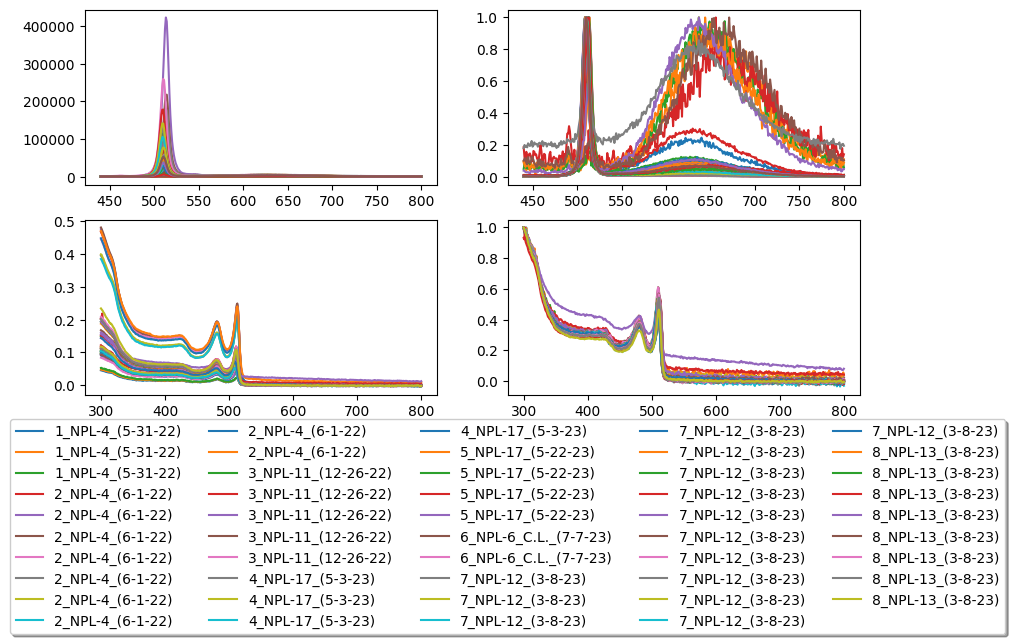

In [94]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

df = pd.read_csv('Data/fl_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[0, 0].plot(df['Wavelength(nm)'], df['Fluorescence'], label=group[0])
    axs[0, 1].plot(df['Wavelength(nm)'], df['Fluorescence_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)

df = pd.read_csv('Data/abs_spectra_data.csv')
for group, df in df.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    axs[1, 0].plot(df['Wavelength(nm)'], df['Absorbance'], label=group[0])
    axs[1, 1].plot(df['Wavelength(nm)'], df['Absorbance_norm'], label=group[0])
plt.legend(loc='upper center', bbox_to_anchor=(0.0, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


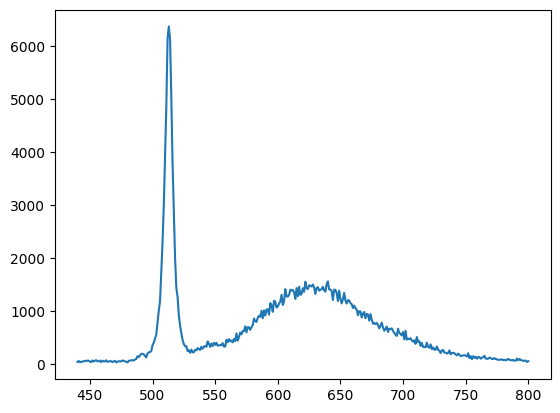

In [34]:
df = pd.read_csv('Data/processed_data.csv')
df.drop(['OD'], axis=1, inplace=True)
df.groupby(['Temperature(C)', 'Doping(%)', 'Time(min)']).count()

sample = df.iloc[0]
w = [float(a) for a in sample['Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample['Fluorescence'][1:-1].split(',')]

plt.plot(w, i, color="C0")

In [36]:
df[['Peak1', "Peak2", "Area1", "Area2"]].describe()

,Peak1,Peak2,Area1,Area2
count,56.000000,56.000000,5.600000e+01,56.000000
mean,510.982143,624.964286,7.803343e+05,257179.276786
std,3.205059,16.252512,8.096359e+05,144278.747123
min,491.000000,550.000000,4.855500e+03,27103.000000
25%,510.000000,618.000000,3.049756e+05,143051.500000
50%,511.000000,625.500000,5.588022e+05,239792.500000
75%,513.000000,630.500000,1.059979e+06,358510.125000
max,514.000000,671.000000,4.619610e+06,525529.000000


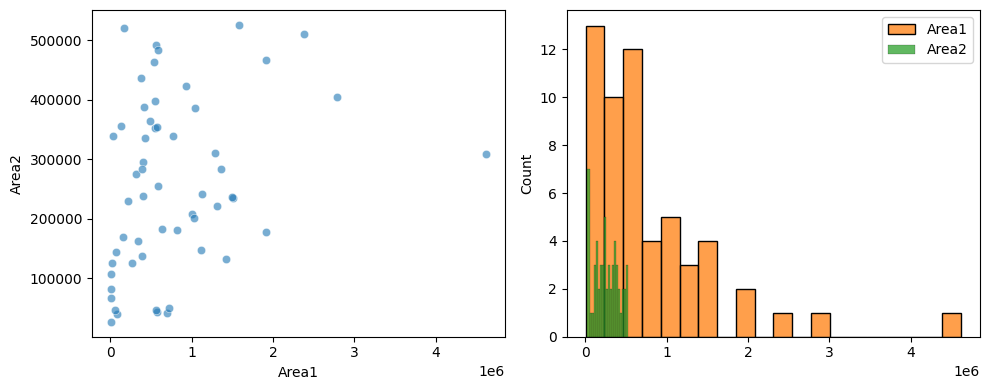

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

labels_auc1 = df['Area1'].to_list()
labels_auc2 = df['Area2'].to_list()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(labels_auc1, labels_auc2, alpha=0.6, color='C0', edgecolors='w', linewidth=0.5)
ax1.set_xlabel('Area1')
ax1.set_ylabel('Area2')

sns.histplot(labels_auc1, bins=20, label='Area1', ax=ax2, color='C1')
sns.histplot(labels_auc2, bins=20, label='Area2', ax=ax2, color='C2')
ax2.legend()

plt.tight_layout()
plt.show()


In [13]:
import dash
from dash.exceptions import PreventUpdate
from dash import dcc, html
from dash.dependencies import Input, Output
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook"
import pandas as pd
import numpy as np
import base64
from io import BytesIO

plotly_df = pd.DataFrame({
    "Area1": df['Area1'].tolist(),
    "Area2": df['Area2'].tolist(),
    "customdata": list(zip(
        df['Fl_Wavelengths'].tolist(), 
        df['Fluorescence'].tolist()
        ))
})
fig = px.scatter(plotly_df, x="Area1", y="Area2", custom_data=["customdata"])
fig.update_layout(clickmode='event+select')
fig.update_traces(marker_size=10)

# Create dash app
app = dash.Dash(__name__)

# Create app layout to show dash graph
app.layout = html.Div([
    html.Div([
        dcc.Graph(
            id="graph_interaction",
            figure=fig,
        )
    ], style={'width': '60%', 'display': 'inline-block'}),

    html.Div([
        html.Img(id='image', src='')
    ], style={'width': '35%', 'display': 'inline-block', 'padding': "20px"})
])

def plot_and_encode_image(data):
    wv = list(map(float, data[0].strip('[]').split(',')))
    fl = list(map(float, data[1].strip('[]').split(',')))
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(wv, fl)
    plt.close(fig)
    
    # Convert plot to PNG image
    buf = BytesIO()
    fig.savefig(buf, format="png")
    
    # Encode PNG image to base64 string
    data = base64.b64encode(buf.getbuffer()).decode("utf8")
    return "data:image/png;base64,{}".format(data)

@app.callback(
    Output('image', 'src'),
    Input('graph_interaction', 'hoverData'))
def update_image(hoverData): 
    if hoverData:
        data_to_plot = hoverData["points"][0]["customdata"][0]
        return plot_and_encode_image(data_to_plot)
    else:
        raise PreventUpdate

if __name__ == '__main__':
   app.run_server(debug=True)